In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader

from src.datasets import ConcatSatelliteDataset, SN7Dataset
from src.datamodules import SN7DataModule
from src.datasources import S2_BANDS12
from src.datautils import ToTensor2, Compose4d, PadCollate, ConcatPadCollate
from src.plot import show

---

# Datasets

These datasets will sample `10000` random patches from the `test` pool of scenes between `Nov 2019` to `Jan 2020`.

In [3]:
date_range = pd.date_range(start=f"2019-11-01", end=f"2020-01-31")
ds_planet = SN7Dataset(sat='planet', date_range=date_range, samples=10_000, labels=True, train_val_test='test', debug=False)
print(ds_planet)

split test
sat planet
start 2019-11-01, end 2020-01-31
scenes 52, samples 10000
labels True
window_size None
transform None
random_seed 1337
data_dir /data/spacenet/train/
band means [0.47, 0.41, 0.3]
band stds [0.16, 0.13, 0.11]


In [4]:
ds_sentinel = SN7Dataset(sat='sentinel', date_range=date_range, samples=10_000, train_val_test='test', debug=False)
print(ds_sentinel)

split test
sat sentinel
start 2019-11-01, end 2020-01-31
scenes 46, samples 10000
labels False
window_size None
transform None
random_seed 1337
data_dir /data/spacenet/train/
band means [1972.0, 1989.0, 2137.0, 2245.0, 2514.0, 2825.0, 2962.0, 3048.0, 3047.0, 3740.0, 2422.0, 2017.0]
band stds [471.0, 517.0, 522.0, 576.0, 565.0, 590.0, 617.0, 674.0, 640.0, 766.0, 596.0, 561.0]


---

Getting an item with the `__getitem__` and an integer index.

In [5]:
item = ds_planet[0]
print(item)

scene L15-0586E-1127N_2345_3680_13
revisits 3
dates ['2019-11-01', '2019-12-01', '2020-01-01']
images (3, 3, 1023, 1024)
clouds (3, 1, 1023, 1024)
labels (3, 1, 1023, 1024)
clearances [1.0, 0.99, 1.0]
band means [93.36, 87.83, 61.24]


In [6]:
item = ds_sentinel[ds_sentinel.scenes[0]]
print(item)

scene L15-0331E-1257N_1327_3160_13
revisits 13
dates ['2019-12-01', '2019-12-06', '2019-12-11', '2019-12-16', '2019-12-21', '2019-12-26', '2019-12-31', '2020-01-05', '2020-01-10', '2020-01-15', '2020-01-20', '2020-01-25', '2020-01-30']
images (13, 12, 489, 490)
clouds (13, 1, 489, 490)
labels None
clearances [1.0, 0.99, 0.03, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.25, 0.43]
band means [3160.34, 3113.09, 3163.93, 3107.4, 3333.02, 3679.4, 3790.79, 3958.91, 3837.5, 4010.13, 2514.54, 2063.07]


---

The item `images` is an `xarray.DataArray`, with TIFF metadata.
(**Disclaimer**: depending on the Dataset transform.)

In [7]:
print(item['images'].crs)
print(item['images'].transform)

+init=epsg:3857
(10.0, 0.0, -13545864.404585794, 0.0, -10.0, 4578883.742395196)


---

## Synchronized gets

Using a `str` scene name with `__getitem__` guarantees that both dataset will get the same scene.

In [8]:
scene = list(set(ds_planet.scenes) & set(ds_sentinel.scenes))[0]

P = ds_planet[scene]
S = ds_sentinel[scene]

print(P['scene'] == S['scene'])
print(scene)

True
L15-0331E-1257N_1327_3160_13


---

On the other hand, using the same `random_seed` generally **DOES NOT** get the same scene. Depending on `year` / `month`, different `Dataset` types point to different scenes.

In [9]:
print(ds_planet[0]['scene'] == ds_sentinel[0]['scene'])

False


---

## `show` images with minimal code

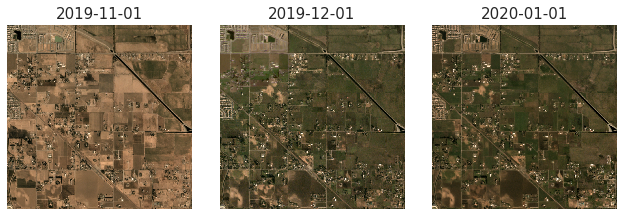

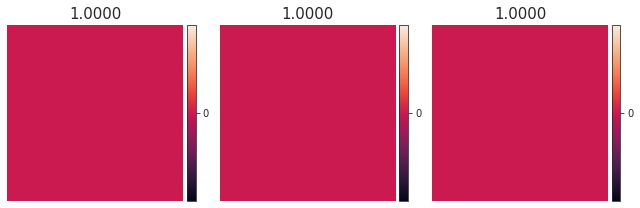

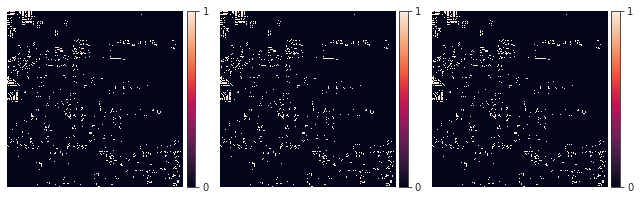

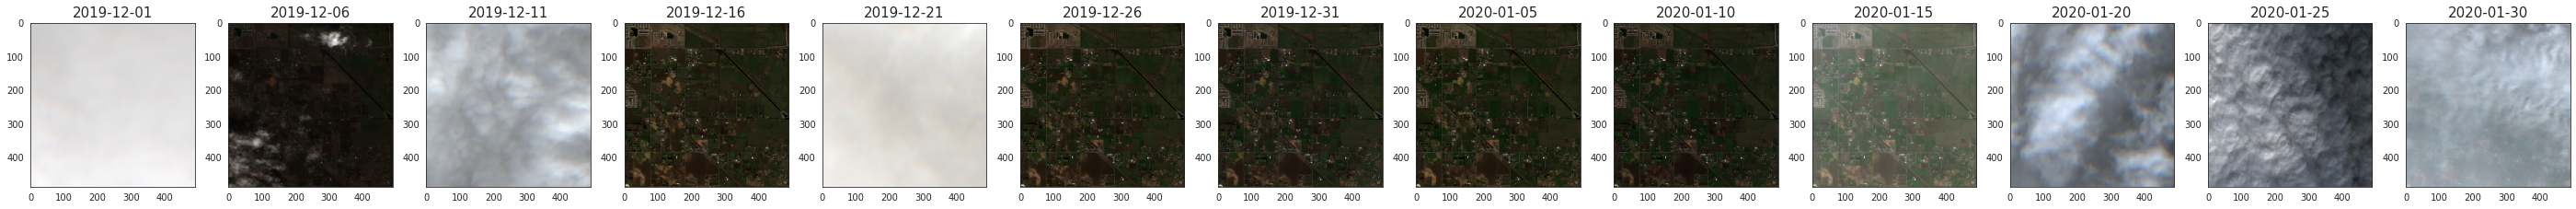

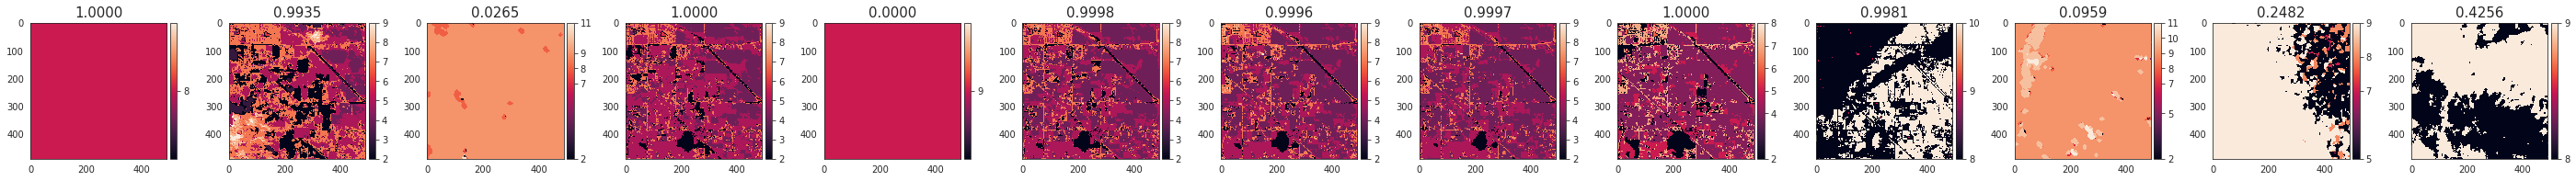

In [11]:
show(P['images'], axis=False)
show(P['clouds'], title=P['clearances'], colorbar=True, normalize=False, axis=False)
show(P['labels'], colorbar=True, normalize=False, axis=False)

S_img = S['images'][:, S2_BANDS['true_color']]
show(S_img)

show(S['clouds'], title=S['clearances'], colorbar=True, normalize=False)

---

# Windows

The `window_size` option set the height and width of window used to sample random patches. If we use the same `Dataset` type, `random_seed` **DOES** get the same scene.

('L15-0586E-1127N_2345_3680_13', (slice(841, 941, None), slice(701, 801, None)))
('L15-0487E-1246N_1950_3207_13', (slice(911, 1011, None), slice(744, 844, None)))


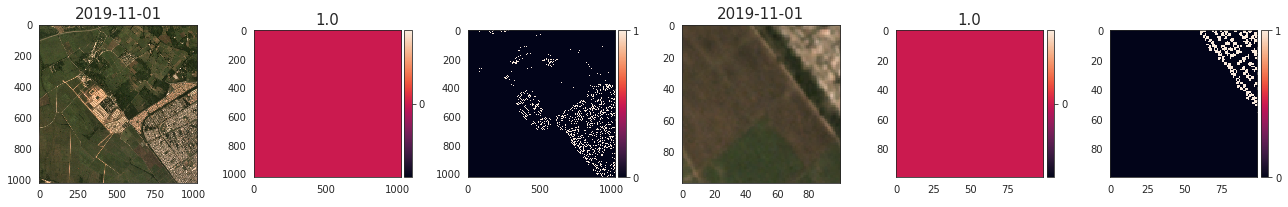

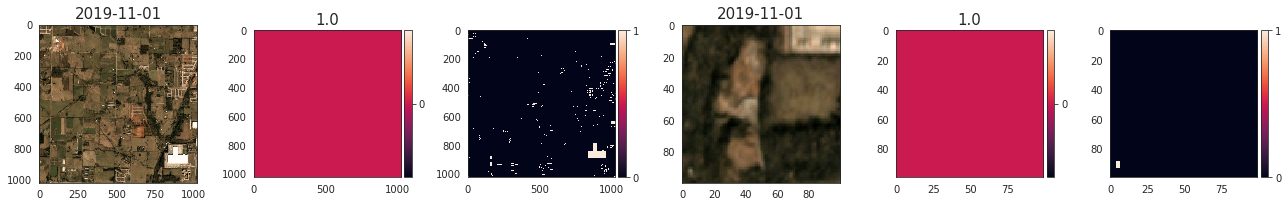

In [13]:
ds_planet = SN7Dataset(sat='planet', date_range=date_range, samples=100, labels=True, train_val_test='test', debug=False)
ds_planet_windowed = SN7Dataset(sat='planet', date_range=date_range, samples=100, window_size=100, labels=True, train_val_test='test', debug=False)

print(ds_planet_windowed.patches[0])
print(ds_planet_windowed.patches[1])

for i in range(2):
    x, m, c, l = (ds_planet[i][k] for k in ['images', 'clouds', 'clearances', 'labels'])
    x2, m2, c2, l2 = (ds_planet_windowed[i][k] for k in ['images', 'clouds', 'clearances', 'labels'])
    show([x[[0]], m[[0]], l[[0]], x2[[0]], m2[[0]], l2[[0]]],
         title=['', float(c[0]), '', '', float(c2[0]), ''], colorbar=True, normalize=False)

---
Showing all sampled windows on the `test` area.

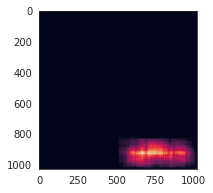

In [18]:
canvas = np.zeros((1024, 1024))
for s, (yslice, xslice) in ds_planet_windowed.patches:
    canvas[yslice, xslice] += 1

show(canvas)

---
We can reset the dataset's `window_size`, which also resets `patches` using the same `random_seed`.

('L15-0977E-1187N_3911_3441_13', (slice(None, None, None), slice(None, None, None)))
('L15-0977E-1187N_3911_3441_13', (slice(415, 479, None), slice(92, 156, None)))


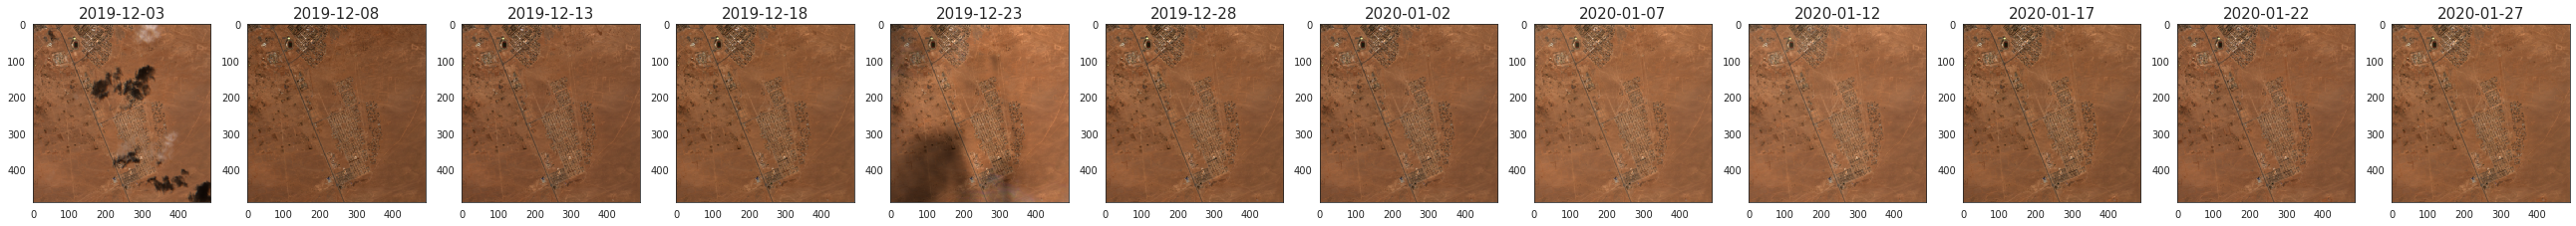

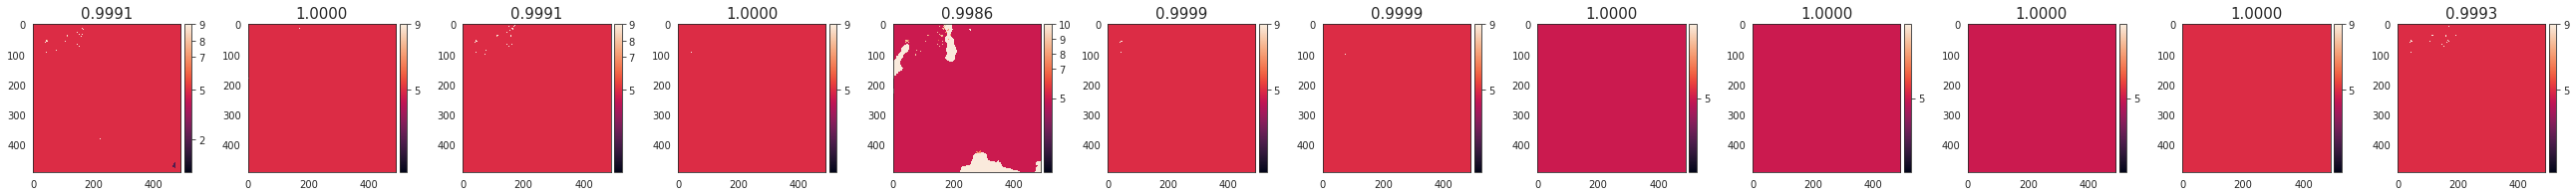

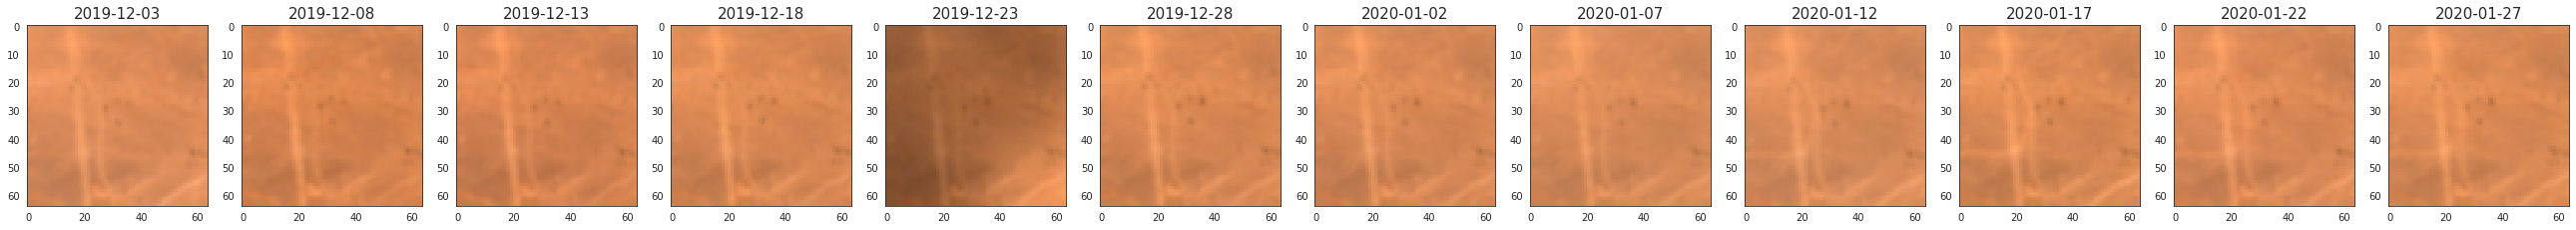

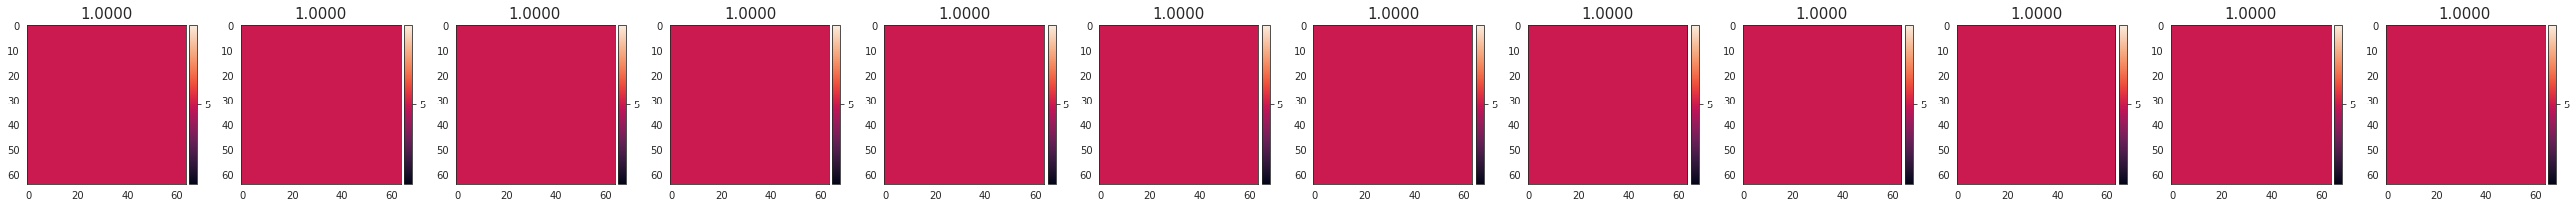

In [21]:
ds_sentinel = SN7Dataset(sat='sentinel', date_range=date_range, samples=50, train_val_test='val', debug=False)
print(ds_sentinel.patches[0])
x, m, c = (ds_sentinel[0][k] for k in ['images', 'clouds', 'clearances'])

ds_sentinel.window_size = 64
print(ds_sentinel.patches[0])
x2, m2, c2 = (ds_sentinel[0][k] for k in ['images', 'clouds', 'clearances'])

show(x[:, S2_BANDS['true_color']])
show(m, title=c, colorbar=True)
show(x2[:, S2_BANDS['true_color']])
show(m2, title=c2, colorbar=True)

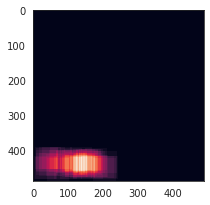

In [22]:
canvas = np.zeros((490, 490))
for s, (yslice, xslice) in ds_sentinel.patches:
    canvas[yslice, xslice] += 1

show(canvas)


---

# Concatenated Dataset

The synchronized gets are used under the hood of a custom ConcatDataset.

First we define the datasets to concatenate.

In [23]:
ds_planet = SN7Dataset(sat='planet', date_range=date_range, samples=5, labels=True, train_val_test='test')
ds_sentinel = SN7Dataset(sat='sentinel', date_range=date_range, samples=5, train_val_test='test')

concat_dataset = ConcatSatelliteDataset((ds_planet, ds_sentinel))

scene L15-0977E-1187N_3911_3441_13
revisits 3
dates ['2019-11-01', '2019-12-01', '2020-01-01']
images (3, 3, 1024, 1024)
clouds (3, 1, 1024, 1024)
labels (3, 1, 1024, 1024)
clearances [1.0, 1.0, 1.0]
band means [198.29, 163.19, 123.87] 

scene L15-0977E-1187N_3911_3441_13
revisits 12
dates ['2019-12-03', '2019-12-08', '2019-12-13', '2019-12-18', '2019-12-23', '2019-12-28', '2020-01-02', '2020-01-07', '2020-01-12', '2020-01-17', '2020-01-22', '2020-01-27']
images (12, 12, 490, 490)
clouds (12, 1, 490, 490)
labels None
clearances [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
band means [1073.26, 1508.77, 2340.91, 3591.33, 3949.64, 4078.69, 4229.16, 4457.88, 4350.4, 4419.18, 5408.26, 4604.89]


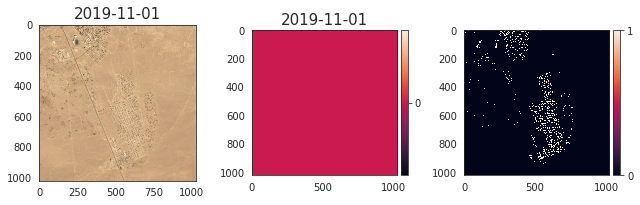

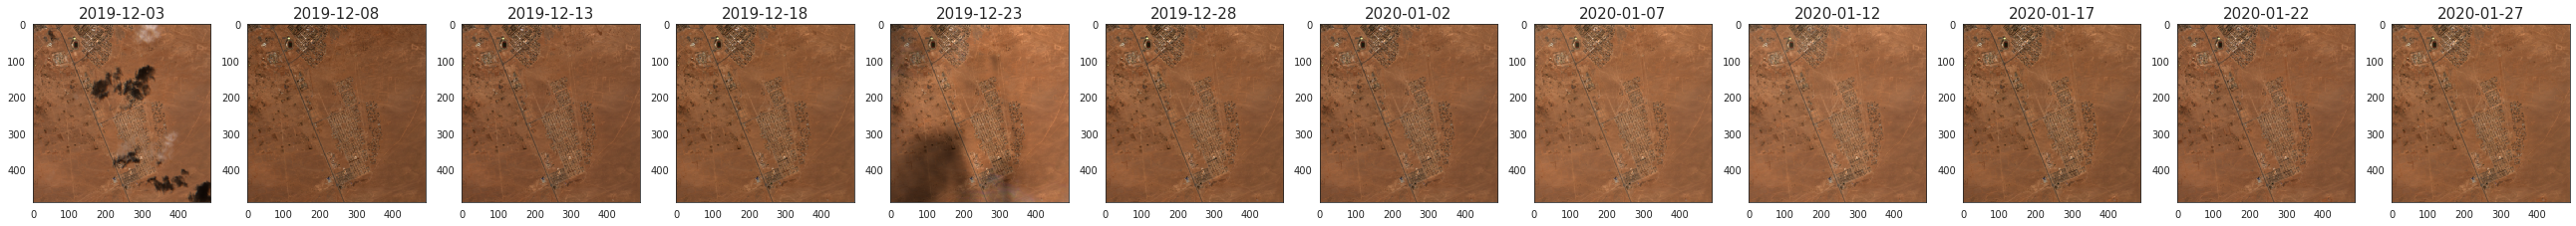

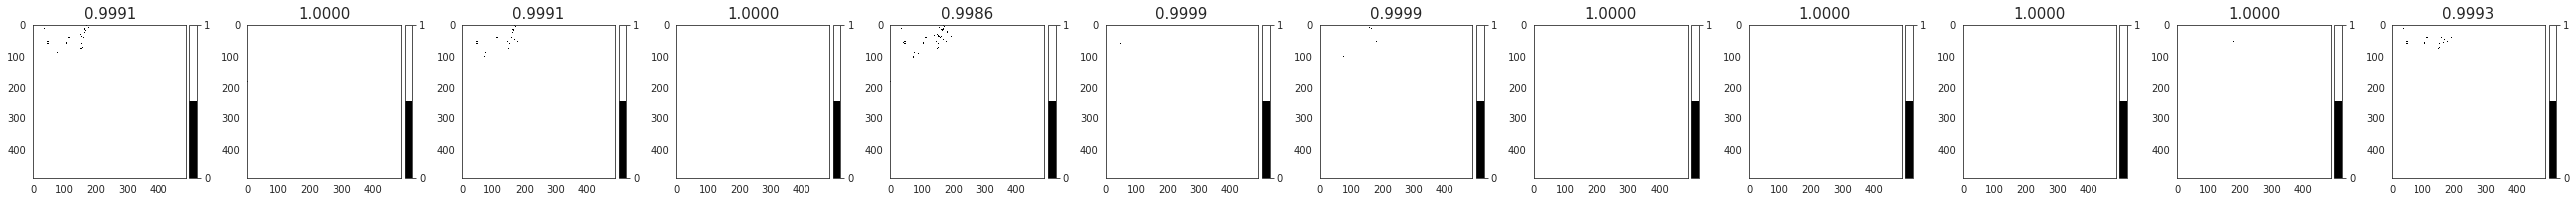

In [24]:
i = 0

item = concat_dataset[i]
hr, lr = item['highres'], item['lowres']
print(hr, '\n')
print(lr)

show([hr['images'][[0]], hr['clouds'][[0]], hr['labels'][[0]]], colorbar=True)
show(lr['images'][:, S2_BANDS['true_color']])
show(ds_sentinel.clearance_masks(lr['clouds']), title=lr['clearances'], colorbar=True)

---
# Concatenated Dataset with windows

In [25]:
ds_planet = SN7Dataset(sat='planet', date_range=date_range, samples=5, labels=True, train_val_test='test')
ds_sentinel = SN7Dataset(sat='sentinel', date_range=date_range, samples=5, train_val_test='test')

concat_dataset_windowed = ConcatSatelliteDataset((ds_planet, ds_sentinel), window_size_planet=134)

scene L15-0977E-1187N_3911_3441_13
revisits 3
dates ['2019-11-01', '2019-12-01', '2020-01-01']
images (3, 3, 134, 134)
clouds (3, 1, 134, 134)
labels (3, 1, 134, 134)
clearances [1.0, 1.0, 1.0]
band means [195.39, 159.21, 121.03] 

scene L15-0977E-1187N_3911_3441_13
revisits 12
dates ['2019-12-03', '2019-12-08', '2019-12-13', '2019-12-18', '2019-12-23', '2019-12-28', '2020-01-02', '2020-01-07', '2020-01-12', '2020-01-17', '2020-01-22', '2020-01-27']
images (12, 12, 65, 64)
clouds (12, 1, 65, 64)
labels None
clearances [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
band means [954.41, 1375.52, 2167.15, 3415.71, 3785.65, 3928.22, 4107.77, 4353.48, 4260.61, 4314.91, 5432.85, 4565.82]


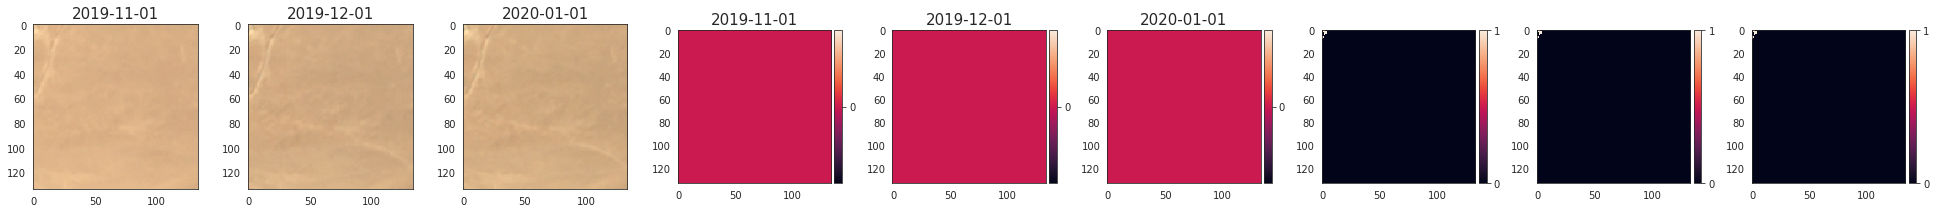

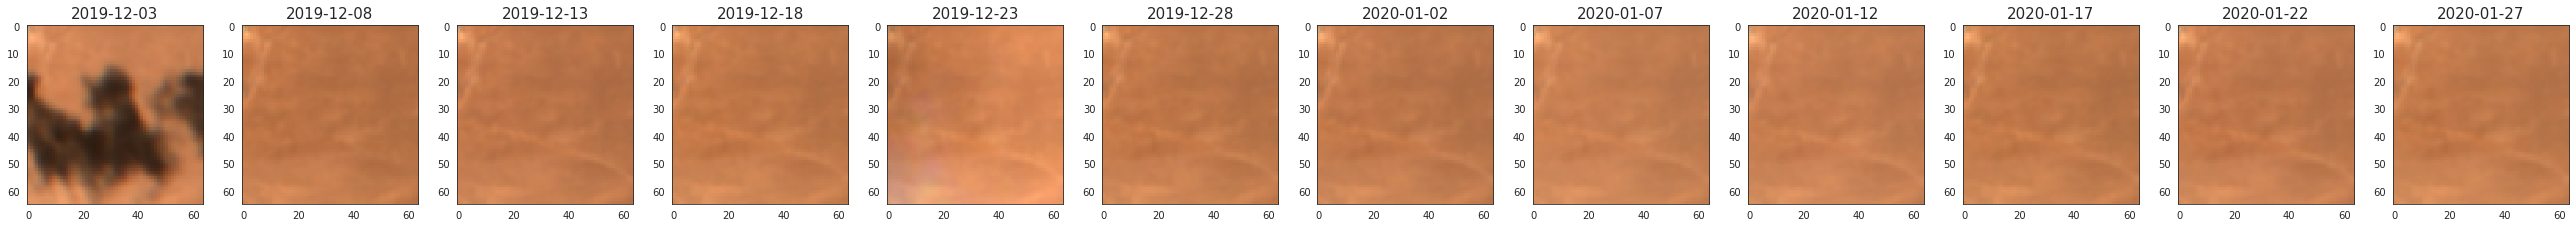

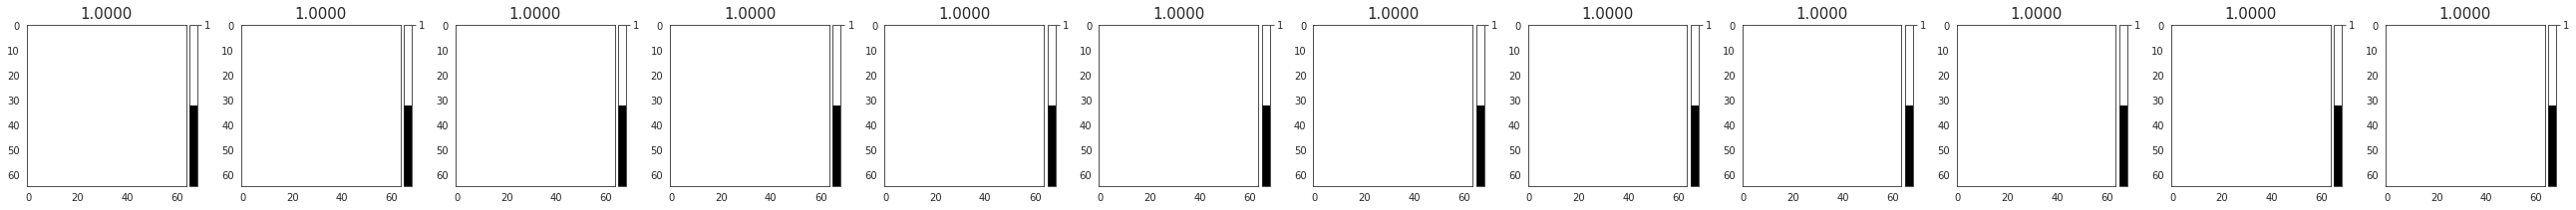

In [26]:
i = 0

item = concat_dataset_windowed[i]

hr, lr = item['highres'], item['lowres']
print(hr, '\n')
print(lr)

show([hr['images'], hr['clouds'], hr['labels']], colorbar=True)
show(lr['images'][:, S2_BANDS['true_color']])
show(ds_sentinel.clearance_masks(lr['clouds']), title=lr['clearances'], colorbar=True)

---

# Dataloaders

To use with `DataLoader`s, the items must be transformed to `Tensor`s.

In [27]:
dataset_sentinel = SN7Dataset(sat='sentinel', date_range=date_range, window_size=64, samples=20, train_val_test='test',
                              transform=Compose4d([ToTensor2()]))

for i in range(5):
    print(f"{i} : {dataset_sentinel[i]['images'].shape}")

0 : torch.Size([12, 12, 64, 64])
1 : torch.Size([13, 12, 64, 64])
2 : torch.Size([12, 12, 64, 64])
3 : torch.Size([12, 12, 64, 64])
4 : torch.Size([12, 12, 64, 64])


Note how size of the Sentinel-2 tensors differ on the **revisits** dimension (and possibly in height / width).
We use `PadCollate` to zero-pad on time / height / width, as needed.

The original number of revisits is saved in `item['revisits']` for masking purposes.

In [28]:
dl = DataLoader(dataset_sentinel, batch_size=4, collate_fn=PadCollate())

print(f"Minibatches: {len(dl)}")
for i, x in enumerate(iter(dl)):
    print(f"{i*dl.batch_size}-{(i+1)*dl.batch_size - 1}: {list(x['images'].shape)}")

Minibatches: 5
0-3: [4, 13, 12, 64, 64]
4-7: [4, 13, 12, 64, 64]
8-11: [4, 13, 12, 64, 64]
12-15: [4, 25, 12, 64, 64]
16-19: [4, 13, 12, 64, 64]


---

**Same with Planet**

In [29]:
dataset_planet = SN7Dataset(sat='planet', date_range=date_range, window_size=100, samples=100, labels=True, train_val_test='test',
                            transform=Compose4d([ToTensor2()]))

for i in range(5):
    print(f"{i} : {dataset_planet[i]['images'].shape}")

0 : torch.Size([3, 3, 100, 100])
1 : torch.Size([3, 3, 100, 100])
2 : torch.Size([3, 3, 100, 100])
3 : torch.Size([3, 3, 100, 100])
4 : torch.Size([3, 3, 100, 100])


In [30]:
dl = DataLoader(dataset_planet, batch_size=16, collate_fn=PadCollate())

print(f"Minibatches: {len(dl)}")
for i, x in enumerate(iter(dl)):
    print(f"{i*dl.batch_size}-{(i+1)*dl.batch_size - 1}: {list(x['images'].shape)}")

Minibatches: 7
0-15: [16, 3, 3, 100, 100]
16-31: [16, 3, 3, 100, 100]
32-47: [16, 3, 3, 100, 100]
48-63: [16, 3, 3, 100, 100]
64-79: [16, 3, 3, 100, 100]
80-95: [16, 3, 3, 100, 100]
96-111: [4, 3, 3, 100, 100]


---

## `DataLoader` for `ConcatDataset`


In [31]:
T = Compose4d([ToTensor2()])

ds_planet = SN7Dataset(sat='planet', date_range=date_range, samples=20, labels=True, train_val_test='test', transform=T)
ds_sentinel = SN7Dataset(sat='sentinel', date_range=date_range, samples=20, train_val_test='test', transform=T)

concat_dataset = ConcatSatelliteDataset((ds_planet, ds_sentinel), window_size_planet=134)

In [32]:
dl = DataLoader(concat_dataset, batch_size=4, collate_fn=ConcatPadCollate())

print(f"Minibatches: {len(dl)}")
for i, x in enumerate(iter(dl)):
    print(f"{i}: {list(x['highres']['images'].shape)}, {list(x['lowres']['images'].shape)}")

Minibatches: 5
0: [4, 3, 3, 134, 134], [4, 13, 12, 65, 65]
1: [4, 3, 3, 134, 134], [4, 13, 12, 64, 64]
2: [4, 3, 3, 134, 134], [4, 13, 12, 65, 65]
3: [4, 3, 3, 134, 134], [4, 25, 12, 65, 64]
4: [4, 3, 3, 134, 134], [4, 13, 12, 64, 64]


---

# DataModule

We use a custom `LightningDataModule` that encapsulates the `Dataset`, `DataLoader`, and `collate_fn`.

In [34]:
date_range = pd.date_range(start=f"2019-11-01", end=f"2020-01-31")
dm = SN7DataModule(date_range=date_range, s2_bands=S2_BANDS['true_color'], labels=True,
                   window_size_planet=64, samples=500, batch_size=32, debug=True)
dm.setup()

print(f"Minibatches: {len(dm.train_dataloader())}")
print(f"Train samples: {len(dm.train_dataloader().dataset)}")
print(f"Val samples: {len(dm.val_dataloader().dataset)}")
print(f"Test samples: {len(dm.val_dataloader().dataset)}")

Minibatches: 13
Train samples: 400
Val samples: 50
Test samples: 50


In [35]:
dls = (dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader())
for dl, split in zip(dls, ('train', 'val', 'test')):
    print(f"\n{split}:")
    for i, x in enumerate(iter(dl)):
        print(f"{i*dm.batch_size}-{(i+1)*dm.batch_size-1}: "
              f"{list(x['highres']['images'].shape)} "
              f"{list(x['highres']['labels'].shape)} "
              f"{list(x['lowres']['images'].shape)}")


train:
0-31: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
32-63: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
64-95: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
96-127: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
128-159: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
160-191: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
192-223: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
224-255: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
256-287: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
288-319: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
320-351: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
352-383: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
384-415: [16, 3, 3, 64, 64] [16, 3, 1, 64, 64] [16, 1, 3, 31, 31]

val:
0-31: [32, 3, 3, 64, 64] [32, 3, 1, 64, 64] [32, 1, 3, 31, 31]
32-63: [18, 3, 3, 64, 64] [18, 3, 1, 64, 64] [18, 1, 3, 31, 31]

test:
0-

---

## A PlanetScope-only `DataModule`

In [36]:
date_range = pd.date_range(start=f"2019-11-01", end=f"2020-01-31")
dm = SN7DataModule(mode='planet', date_range=date_range, s2_bands=S2_BANDS['true_color'], labels=True,
                   window_size_planet=32, samples=500, batch_size=32, debug=True)

dm.setup()

print(f"Minibatches: {len(dm.train_dataloader())}")
print(f"Train samples: {len(dm.train_dataloader().dataset)}")
print(f"Val samples: {len(dm.val_dataloader().dataset)}")
print(f"Test samples: {len(dm.val_dataloader().dataset)}")

dls = (dm.train_dataloader(), dm.val_dataloader(), dm.test_dataloader())
for dl, split in zip(dls, ('train', 'val', 'test')):
    print(f"\n{split}:")
    for i, x in enumerate(iter(dl)):
        print(f"{i*dm.batch_size}-{(i+1)*dm.batch_size-1}: "
              f"{list(x['images'].shape)} "
              f"{list(x['labels'].shape)}")

Minibatches: 13
Train samples: 400
Val samples: 50
Test samples: 50

train:


0-31: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
32-63: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
64-95: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
96-127: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
128-159: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
160-191: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
192-223: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
224-255: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
256-287: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
288-319: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
320-351: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
352-383: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
384-415: [16, 3, 3, 32, 32] [16, 3, 1, 32, 32]

val:
0-31: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
32-63: [18, 3, 3, 32, 32] [18, 3, 1, 32, 32]

test:
0-31: [32, 3, 3, 32, 32] [32, 3, 1, 32, 32]
32-63: [18, 3, 3, 32, 32] [18, 3, 1, 32, 32]


---